# Arbitrary Butcher Tableaus and Adaptive Integration

In this notebook, we will go through the process of expanding our code in order to allow for different Butcher tableaus and how to implement a step-size adaptation algorithm.

We have moved the `compensated_sum` function into our module under `neuralode.util.compensated_sum` and added a function `neuralode.util.partial_compensated_sum` that can be called with the partial sums and truncated bits for iteratively updated the tracked values. This simplifies our integration code by removing the duplication.

The plotting code has been moved into `neuralode.plot.trajectory.plot_trajectory` and `neuralode.plot.trajectory.plot_trajectory_with_reference`. The `neuralode.plot.trajectory.plot_trajectory` plots a trajectory without a reference solution which we will encounter with systems that don't have a closed form solution. We will be using the concept of a reference where a higher precision solver can be used to compute the trajectory. 

In [1]:
import functools
import typing
import warnings

import torch
import neuralode

In [2]:
# For convenience, we define the default tensor device and dtype here
torch.set_default_device('cpu')
# In neural networks, we prefer 32-bit/16-bit floats, but for precise integration, 64-bit is preferred. We will revisit this later when we need to mix integration with neural network training
torch.set_default_dtype(torch.float64) 

We'll be starting with the same function from the previous notebook, but we have tidied up the code by using `neuralode.util.partial_compensated_sum` to track the truncated bits instead of duplicating the code through our integration function.

In [3]:
class IntegrateRK4(torch.autograd.Function):
    @staticmethod
    def forward(ctx, fn, x0, t0, t1, dt):
        """
        A general integration routine for solving an Initial Value Problem
        using the Classical Fourth-Order Method.
        
        Instead of naively summing the changes, we use compensated summation.
        
        :param fn: the function to be integrated
        :param initial_state: the initial state to integrate from
        :param initial_time: the initial time to integrate from
        :param final_time: the final time to integrate to
        :param timestep: the time increments to integrate with 
        :return: a tuple of ((the final state, the final time), the intermediates states [list]) 
        """
        # The names for the variables have been shortened for concision, and
        # to avoid overlap with variables in the outer scope
        # I have also left the annotations as they are invaluable for tracking the method. 
        c_time = t0.clone()
        c_state = x0.clone()
        
        # We'd like to track the whole trajectory, not just the final state, so we use a list to store the intermediate states and times
        i_states = [(c_state.clone(), c_time.clone())]
        
        # We write out the butcher tableau for easier computation
        butcher_tableau = torch.tensor([
            # c0, a00, a01, a02, a03
            [0.0, 0.0, 0.0, 0.0, 0.0],
            # c1, a10, a11, a12, a13
            [0.5, 0.5, 0.0, 0.0, 0.0],
            # c2, a20, a21, a22, a23
            [0.5, 0.0, 0.5, 0.0, 0.0],
            # c3, a30, a31, a32, a33
            [1.0, 0.0, 0.0, 1.0, 0.0],
            #     b0,  b1,  b2,  b3
            [0.0, 1/6, 2/6, 2/6, 1/6]
        ], dtype=x0.dtype, device=x0.device)
        # We see here that this method of writing out the tableau, while complete,
        # is inefficient given that so many entries are zero.
        # Ideally, we would have a more compressed format, but for our purposes,
        # this works.
        
        # At each step we repeat the same procedure with differing states and times 
        # (and step sizes for the last step), thus it makes sense to 
        # wrap everything in a local function which can be called repeatedly.
        def compute_step(state, time, step):
            # We need to store the intermediate stages
            k_stages = torch.stack([torch.zeros_like(time)]*(butcher_tableau.shape[1] - 1))
            # we subtract one since the last row is the final state
            for stage_index in range(butcher_tableau.shape[0] - 1):
                c_coeff, *a_coeff = butcher_tableau[stage_index]
                k_stages[stage_index] = fn(
                    # We use `compensated_sum` instead of sum in order to avoid truncation at each stage calculation
                    state + step * neuralode.util.compensated_sum(k*a for k,a in zip(k_stages, a_coeff)), 
                    time + c_coeff * step
                )
            # We return the change in the state and the change in the time as we track partial sums
            # Again, we use `compensated_sum` to avoid truncation in the final stage calculations
            return step * neuralode.util.compensated_sum(k*b for k,b in zip(k_stages, butcher_tableau[-1, 1:])), step
        
        c_state, truncated_bits_state = neuralode.util.partial_compensated_sum(c_state)
        c_time,  truncated_bits_time  = neuralode.util.partial_compensated_sum(c_time)
        
        # We integrate as long as the current_time+dt is less than t1
        # Essentially, we want to stop the integration if taking another step
        # would lead to exceeding the final time
        while torch.any((c_time + dt) < t1):
            # To compute the change in state, we add the truncated bits back
            delta_state, delta_time = compute_step(c_state, c_time, dt)
            c_state, truncated_bits_state = neuralode.util.partial_compensated_sum(delta_state, (c_state, truncated_bits_state))
            c_time,  truncated_bits_time  = neuralode.util.partial_compensated_sum(delta_time, (c_time, truncated_bits_time))
            # We would like to store the intermediate states with the compensated partial sums
            i_states.append((c_state + truncated_bits_state, c_time + truncated_bits_time))
            
        delta_state, delta_time = compute_step(c_state + truncated_bits_state, c_time + truncated_bits_time, t1 - (c_time + truncated_bits_time))
        c_state, truncated_bits_state = neuralode.util.partial_compensated_sum(delta_state, (c_state, truncated_bits_state))
        c_time,  truncated_bits_time  = neuralode.util.partial_compensated_sum(delta_time, (c_time, truncated_bits_time))
        
        i_states.append((c_state + truncated_bits_state, c_time + truncated_bits_time))
        
        ctx.save_for_backward((c_state, c_time, i_states))
        ctx.integration_function = fn
        
        return (c_state, c_time), i_states

Similarly, we'll test our implementation on the same exponential system before moving on.

In [4]:
def exponential_fn(x, t):
    """
    The derivative of an exponential system
    :param x: the current state of the system
    :param t: the current time of the system
    :return: the derivative of the exponential system at (x,t)
    """
    return -x

def exponential_fn_solution(initial_state, t):
    """
    The solution of an exponentially decaying system
    :param initial_state: the initial state of the systme
    :param t: the time at which the solution is desired
    :return: the state at time t
    """
    return initial_state*torch.exp(-t)

In [5]:
x0 = torch.tensor([1.0])
t0 = torch.tensor(0.0)
t1 = torch.tensor(1.0)
N  = 5
dt = (t1 - t0) / N

Error in RK4: 5.79695385960477e-06


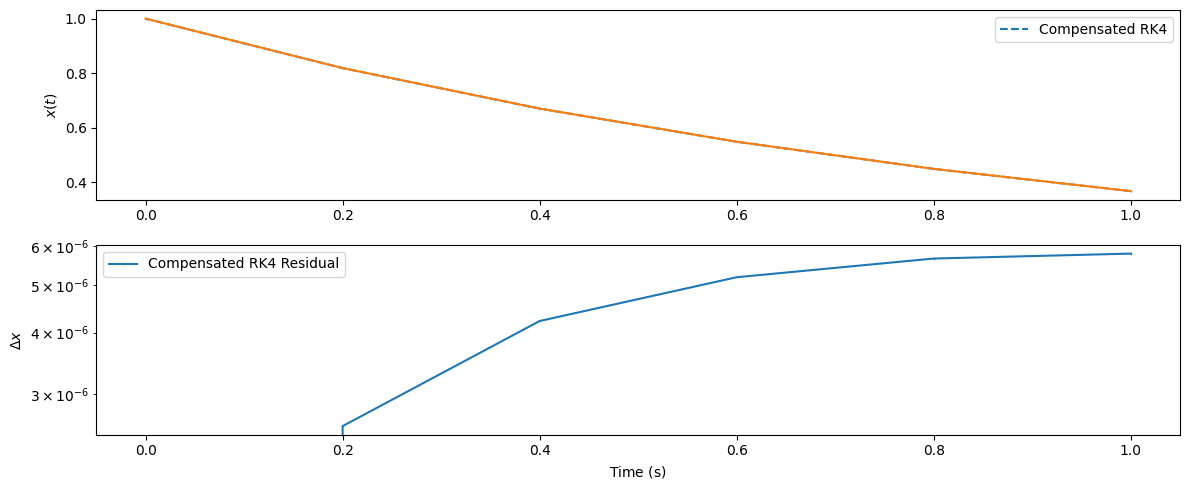

In [6]:
(f_state, f_time), sub_states = IntegrateRK4.apply(exponential_fn, x0, t0, t1, dt)
reference_trajectory = [exponential_fn_solution(x0, t) for _,t in sub_states]

fig, axes = neuralode.plot.trajectory.plot_trajectory_with_reference(sub_states, reference_trajectory, method_label="Compensated RK4")

print(f"Error in RK4: {(f_state - exponential_fn_solution(x0, t1)).abs().item()}")

Now that we have verified that the previous code is still correct and working with our code in the module, we can start parametrisation of the integrator as a function of the Butcher Tableau.

The following code takes advantage of the dynamic type system in Python, more specifically, we can generate a class and define its methods dynamically as well as store the tableau itself as an attribute of the class. In this fashion, we can have a function that takes a tableau as a PyTorch tensor and returns a PyTorch function that can integrate a system.

This will enable us to test out different integration algorithms without having to write a new class for each one. Eventually we will move this function into the module and add different integration algorithms at import time.

In [7]:
def get_integrator(integrator_tableau: torch.Tensor, integrator_name: str = None) -> torch.autograd.Function:
    __integrator_type = type(integrator_name, (torch.autograd.Function,), {
        "integrator_tableau": integrator_tableau
    })
    def __internal_forward(ctx, fn, x0, t0, t1, dt):
        """
        A general integration routine for solving an Initial Value Problem
        using any arbitrary Butcher Tableau
        
        Instead of naively summing the changes, we use compensated summation.
        
        :param fn: the function to be integrated
        :param initial_state: the initial state to integrate from
        :param initial_time: the initial time to integrate from
        :param final_time: the final time to integrate to
        :param timestep: the time increments to integrate with 
        :return: a tuple of ((the final state, the final time), the intermediates states [list]) 
        """
        c_time = t0.clone()
        c_state = x0.clone()
        
        i_states = [(c_state.clone(), c_time.clone())]
        
        butcher_tableau = __integrator_type.integrator_tableau.clone().to(x0.device, x0.dtype)

        def compute_step(state, time, step):
            # We need to store the intermediate stages
            k_stages = torch.stack([torch.zeros_like(time)]*(butcher_tableau.shape[1] - 1))
            # we subtract one since the last row is the final state
            for stage_index in range(butcher_tableau.shape[0] - 1):
                c_coeff, *a_coeff = butcher_tableau[stage_index]
                k_stages[stage_index] = fn(
                    # We use `compensated_sum` instead of sum in order to avoid truncation at each stage calculation
                    state + step * neuralode.util.compensated_sum(k*a for k,a in zip(k_stages, a_coeff)), 
                    time + c_coeff * step
                )
            return step * neuralode.util.compensated_sum(k*b for k,b in zip(k_stages, butcher_tableau[-1, 1:])), step
        
        c_state, truncated_bits_state = neuralode.util.partial_compensated_sum(c_state)
        c_time,  truncated_bits_time  = neuralode.util.partial_compensated_sum(c_time)
        
        while torch.any((c_time + dt) < t1):
            delta_state, delta_time = compute_step(c_state + truncated_bits_state, c_time + truncated_bits_time, dt)
            c_state, truncated_bits_state = neuralode.util.partial_compensated_sum(delta_state, (c_state, truncated_bits_state))
            c_time,  truncated_bits_time  = neuralode.util.partial_compensated_sum(delta_time, (c_time, truncated_bits_time))
            
            i_states.append((c_state + truncated_bits_state, c_time + truncated_bits_time))
            
        delta_state, delta_time = compute_step(c_state + truncated_bits_state, c_time + truncated_bits_time, (t1 - c_time) - truncated_bits_time)
        c_state, truncated_bits_state = neuralode.util.partial_compensated_sum(delta_state, (c_state, truncated_bits_state))
        c_time,  truncated_bits_time  = neuralode.util.partial_compensated_sum(delta_time, (c_time, truncated_bits_time))
        
        i_states.append((c_state + truncated_bits_state, c_time + truncated_bits_time))
        
        ctx.save_for_backward((c_state, c_time, i_states))
        ctx.integration_function = fn
        
        return (c_state, c_time), i_states        
    __integrator_type.forward = staticmethod(__internal_forward)
    return __integrator_type

In [8]:
explicit_rk4_integrator = get_integrator(torch.tensor([
            # c0, a00, a01, a02, a03
            [0.0, 0.0, 0.0, 0.0, 0.0],
            # c1, a10, a11, a12, a13
            [0.5, 0.5, 0.0, 0.0, 0.0],
            # c2, a20, a21, a22, a23
            [0.5, 0.0, 0.5, 0.0, 0.0],
            # c3, a30, a31, a32, a33
            [1.0, 0.0, 0.0, 1.0, 0.0],
            #     b0,  b1,  b2,  b3
            [0.0, 1/6, 2/6, 2/6, 1/6]
        ], dtype=torch.float64), integrator_name = "ExplicitRungeKutta4")
explicit_midpoint_integrator = get_integrator(torch.tensor([
            # c0, a00, a01
            [0.0, 0.0, 0.0],
            # c1, a10, a11
            [0.5, 0.5, 0.0],
            #     b0,  b1
            [0.0, 0.0, 1.0]
        ], dtype=torch.float64), integrator_name = "ExplicitMidpoint")

Error in <class '__main__.ExplicitMidpoint'>: 1.5334058023341868e-08
Error in <class '__main__.ExplicitRungeKutta4'>: 2.220446049250313e-16


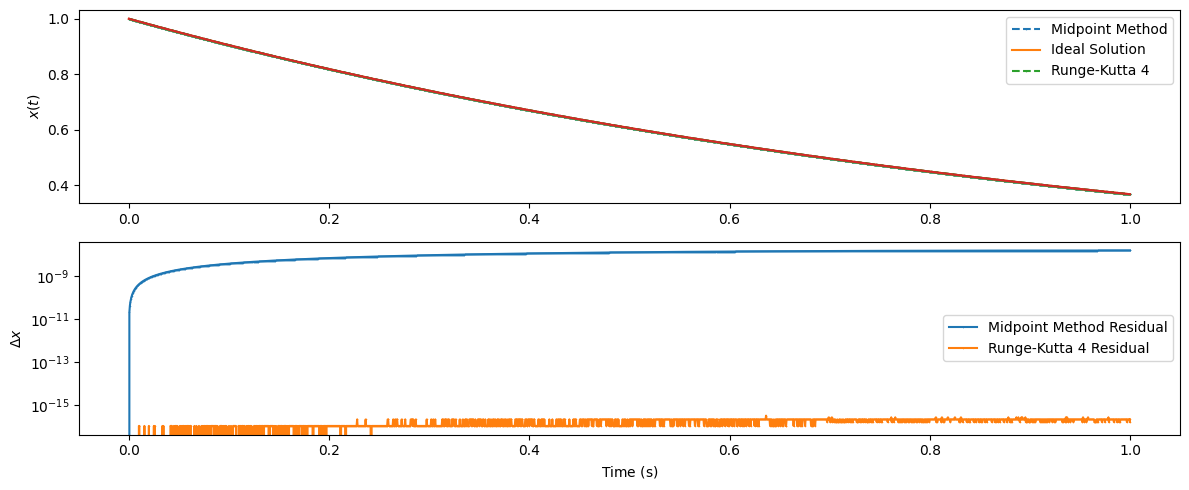

In [9]:
dt = (t1 - t0)/2000

(f_state, f_time), sub_states = explicit_midpoint_integrator.apply(exponential_fn, x0, t0, t1, dt)
reference_trajectory = [exponential_fn_solution(x0, t) for _,t in sub_states]

print(f"Error in {explicit_midpoint_integrator}: {(f_state - exponential_fn_solution(x0, t1)).abs().item()}")

fig, axes = neuralode.plot.trajectory.plot_trajectory_with_reference(sub_states, reference_trajectory, method_label="Midpoint Method")

(f_state, f_time), sub_states = explicit_rk4_integrator.apply(exponential_fn, x0, t0, t1, dt)
fig, axes = neuralode.plot.trajectory.plot_trajectory_with_reference(sub_states, reference_trajectory, axes=axes, method_label="Runge-Kutta 4")

print(f"Error in {explicit_rk4_integrator}: {(f_state - exponential_fn_solution(x0, t1)).abs().item()}")

We can see that this simplifies testing of different integration methods, and we could even use it to optimise the tableau itself since PyTorch allows for differentiating tensor variables (but I digress). For now, we will focus on how to implement an adaptive integration scheme. To identify whether a tableau if adaptive, we can use the first column of the rows with the $b_i$ coefficients and put a `torch.inf` value in their place. As this value is ignored during integration, it will be a way of signalling that the rows with `torch.inf` are used as the $b_i$ coefficients.  

Let's implement this!

In [10]:
def get_integrator(integrator_tableau: torch.Tensor, integrator_order: int, use_local_extrapolation: bool = True, integrator_name: str = None) -> torch.autograd.Function:
    # We look at the first column of the last two rows, and if both are `inf`, we know the method is adaptive
    is_adaptive = torch.isinf(integrator_tableau[-1,0]) and torch.isinf(integrator_tableau[-2,0])
    # The number of stages is the number of rows minus the last row
    # (or last two rows if the method is adaptive)
    number_of_stages = integrator_tableau.shape[0] - 1
    if is_adaptive:
        number_of_stages -= 1
    # The `type` function in this form works to dynamically create a class
    # the first parameter is the class name, the second are parent classes,
    # and the last are the class attributes. We store the integrator attributes 
    # here, and reference them in the integration code.
    # In this way, we can query these parameters at a future point.
    __integrator_type = type(integrator_name, (torch.autograd.Function,), {
        "integrator_tableau": integrator_tableau,
        "integrator_order": integrator_order,
        "is_adaptive": is_adaptive,
        "number_of_stages": number_of_stages
    })
    def __internal_forward(ctx, fn: typing.Callable[[torch.Tensor, torch.Tensor], torch.Tensor], 
                           x0: torch.Tensor, t0: torch.Tensor, t1: torch.Tensor, dt: torch.Tensor,
                           atol: torch.Tensor, rtol: torch.Tensor):
        """
        A general integration routine for solving an Initial Value Problem
        using any arbitrary Butcher Tableau
        
        Instead of naively summing the changes, we use compensated summation.
        
        :param fn: the function to be integrated
        :param initial_state: the initial state to integrate from
        :param initial_time: the initial time to integrate from
        :param final_time: the final time to integrate to
        :param timestep: the time increments to integrate with 
        :return: a tuple of ((the final state, the final time), the intermediate states [list[torch.Tensor]], the error values [list[torch.Tensor]]) 
        """        
        if __integrator_type.is_adaptive:
            # We need to check that both `atol` and `rtol` are valid values and are compatible with the state
            atol = torch.abs(atol) # Need to ensure that the tolerance is a strictly positive number
            if atol.dim() != 0:
                # We can set per-component tolerances, but that means that the shapes of x0 and atol/rtol are compatible.
                # To test this, we try to add the tolerance to the initial state and check for errors
                try:
                    _ = x0.clone() + atol.clone()
                except RuntimeError:
                    raise ValueError(f"Expected shape of x0 and atol to be compatible, got {x0.shape} and {atol.shape} respectively")
            # 
            if torch.any((atol < torch.finfo(x0.dtype).eps) & (atol != 0.0)):
                # If any component of `atol` is too small, we adjust the values to be compatible with the datatype
                # To preserve differentiability, we divide out the detached value of `atol` and multiply by the epsilon 
                warnings.warn(f"Absolute tolerance is too small for tensor dtype: {x0.dtype}. Set atol={torch.finfo(x0.dtype).eps}.")
                atol = torch.where((atol < torch.finfo(x0.dtype).eps) & (atol != 0.0), (atol/atol.detach())*torch.finfo(x0.dtype).eps, atol) 
            elif torch.any(atol < torch.finfo(x0.dtype).eps**0.5):
                # When the tolerances are tiny (roughly eps^0.5), truncation error can start to dominate
                # while we are compensating for this using Kahan summation, the user should be informed that this may cause issues.
                warnings.warn(f"Absolute tolerance is smaller than the square root of the epsilon for {x0.dtype}, this may increase truncation error")
            rtol = torch.abs(rtol) # Need to ensure that the tolerance is a strictly positive number
            if rtol.dim() != 0:
                # We can set per-component tolerances, but that means that the shapes of x0 and atol/rtol are compatible.
                # To test this, we try to add the tolerance to the 
                try:
                    _ = x0.clone() + rtol.clone()
                except RuntimeError:
                    raise ValueError(f"Expected shape of x0 and rtol to be compatible, got {x0.shape} and {rtol.shape} respectively")
            # 
            if torch.any((rtol < torch.finfo(x0.dtype).eps) & (rtol != 0.0)):
                # If any component of `rtol` is too small, we adjust the values to be compatible with the datatype
                # To preserve differentiability, we divide out the detached value of `rtol` and multiply by the epsilon 
                warnings.warn(f"Relative tolerance is too small for tensor dtype: {x0.dtype}. Set rtol={torch.finfo(x0.dtype).eps}.")
                rtol = torch.where((rtol < torch.finfo(x0.dtype).eps) & (rtol != 0.0), (rtol/rtol.detach())*torch.finfo(x0.dtype).eps, rtol) 
            elif torch.any(rtol < torch.finfo(x0.dtype).eps**0.5):
                # When the tolerances are tiny (roughly eps^0.5), truncation error can start to dominate
                # while we are compensating for this using Kahan summation, the user should be informed that this may cause issues.
                warnings.warn(f"Relative tolerance is smaller than the square root of the epsilon for {x0.dtype}, this may increase truncation error")
        
        if torch.any(torch.sign(t1 - t0) != torch.sign(dt)):
            # When dt points in a different direction to the direction of integration, this will cause issues in our integration loop
            # we either correct this or raise an error, we've elected to resolve this silently
            warnings.warn(f"Different sign of (t1 - t0) and dt: {t1 - t0} and {dt}, correcting...")
            dt = torch.copysign(dt, t1 - t0)            
        
        c_state = x0.clone()
        c_time = t0.clone()
        
        i_states = [(c_state.clone(), c_time.clone())]
        
        butcher_tableau = __integrator_type.integrator_tableau.clone().to(x0.device, x0.dtype)
        error_in_state = [torch.zeros(tuple(), device=x0.device, dtype=x0.dtype)]

        def compute_step(state, time, step):
            # We need to store the intermediate stages
            k_stages = torch.stack([torch.zeros_like(time)]*__integrator_type.number_of_stages)
            # we subtract one since the last row is the final state
            for stage_index in range(__integrator_type.number_of_stages):
                c_coeff, *a_coeff = butcher_tableau[stage_index]
                k_stages[stage_index] = fn(
                    # We use `compensated_sum` instead of `sum` to avoid truncation at each stage calculation
                    state + step * neuralode.util.compensated_sum(k*a for k,a in zip(k_stages, a_coeff)), 
                    time + c_coeff * step
                )
            lower_order_estimate = step * neuralode.util.compensated_sum(k*b for k,b in zip(k_stages, butcher_tableau[-1, 1:]))
            # To have a valid value, we set `higher_order_estimate` to the same value as `lower_order_estimate`
            # Further down, this will simplify the code as we won't have to account for invalid values 
            higher_order_estimate = lower_order_estimate
            if __integrator_type.is_adaptive:
                higher_order_estimate = step * neuralode.util.compensated_sum(k*b for k,b in zip(k_stages, butcher_tableau[-2, 1:]))
            # From a numerical perspective, this implementation is not necessarily ideal as
            # we can lose precision when subtracting the two solutions. A more numerically accurate
            # implementation would have one row `b_i` coefficients and another row the coefficients
            # for computing the error directly
            return lower_order_estimate, higher_order_estimate, step
        
        c_state, truncated_bits_state = neuralode.util.partial_compensated_sum(c_state)
        c_time,  truncated_bits_time  = neuralode.util.partial_compensated_sum(c_time)
        
        while torch.any((c_time + dt) < t1):
            delta_state_lower, delta_state_upper, delta_time = compute_step(c_state + truncated_bits_state, c_time + truncated_bits_time, dt)
            # If local extrapolation is enabled, we take the higher order estimate, otherwise the lower order one
            delta_state = delta_state_upper if use_local_extrapolation else delta_state_lower
            
            # We use `torch.linalg.norm` to compute the magnitude of the error
            # we can adjust this by passing in the `ord` keyword to choose a different
            # vector norm, but the 2-norm suffices for our purposes
            error_in_state.append(torch.linalg.norm(delta_state_upper - delta_state_lower))
            if __integrator_type.is_adaptive:
                # To save on computation, we only compute the max error tolerated and the step 
                # correction when the method is adaptive
                max_error = atol + torch.linalg.norm(rtol * c_state)
                step_correction = 0.8*torch.where(error_in_state[-1] != 0.0, max_error/error_in_state[-1], 1.0)**(1/integrator_order)
                # Based on the error, we correct the step size
                dt = step_correction*dt
                if error_in_state[-1] >= max_error:
                    # If the error exceeds our error threshold, we don't commit the step and redo it
                    continue
            c_state, truncated_bits_state = neuralode.util.partial_compensated_sum(delta_state, (c_state, truncated_bits_state))
            c_time,  truncated_bits_time  = neuralode.util.partial_compensated_sum(delta_time, (c_time, truncated_bits_time))
            
            i_states.append((c_state + truncated_bits_state, c_time + truncated_bits_time))
            
        delta_state_lower, delta_state_upper, delta_time = compute_step(c_state + truncated_bits_state, c_time + truncated_bits_time, (t1 - c_time) - truncated_bits_time)
        delta_state = delta_state_upper if use_local_extrapolation else delta_state_lower
        c_state, truncated_bits_state = neuralode.util.partial_compensated_sum(delta_state, (c_state, truncated_bits_state))
        c_time,  truncated_bits_time  = neuralode.util.partial_compensated_sum(delta_time, (c_time, truncated_bits_time))
            
        error_in_state.append(torch.linalg.norm(delta_state_upper - delta_state_lower))
        
        i_states.append((c_state + truncated_bits_state, c_time + truncated_bits_time))
        
        # We save parameters for the backward pass, but these won't be used 
        # until we implement the adjoint method for backpropagation
        ctx.save_for_backward((c_state, c_time, i_states))
        ctx.integration_function = fn
        
        return (c_state, c_time), i_states, error_in_state
    
    if not __integrator_type.is_adaptive:
        # If the method isn't adaptive, neither atol nor rtol are required, but because of
        # how `torch.autograd.Function` works, we cannot have keyword arguments
        # For that reason, we use `functools.partial` to fill those values with a stub
        __internal_forward = functools.partial(__internal_forward, atol=torch.inf, rtol=torch.inf)
    __integrator_type.forward = staticmethod(__internal_forward)
    return __integrator_type

In [11]:
adaptive_rk45_integrator_without_local_extrapolation = get_integrator(torch.tensor([
    [0.0,       0.0,         0.0,        0.0,         0.0,      0.0,          0.0,      0.0 ],
    [1/5,       1/5,         0.0,        0.0,         0.0,      0.0,          0.0,      0.0 ],
    [3/10,      3/40,        9/40,       0.0,         0.0,      0.0,          0.0,      0.0 ],
    [4/5,       44/45,      -56/15,      32/9,        0.0,      0.0,          0.0,      0.0 ],
    [8/9,       19372/6561, -25360/2187, 64448/6561, -212/729,  0.0,          0.0,      0.0 ],
    [1.0,       9017/3168,  -355/33,     46732/5247,  49/176,  -5103/18656,   0.0,      0.0 ],
    [1.0,       35/384,      0.0,        500/1113,    125/192, -2187/6784,    11/84,    0.0 ],
    [torch.inf, 35/384,      0.0,        500/1113,    125/192, -2187/6784,    11/84,    0.0 ],
    [torch.inf, 5179/57600,  0.0,        7571/16695,  393/640, -92097/339200, 187/2100, 1/40]
], dtype=torch.float64), integrator_order = 5, use_local_extrapolation = False, integrator_name = "AdaptiveRK45IntegratorNoLocalExtrapolation")
adaptive_rk45_integrator_with_local_extrapolation = get_integrator(adaptive_rk45_integrator_without_local_extrapolation.integrator_tableau, integrator_order = 5, use_local_extrapolation = True, integrator_name = "AdaptiveRK45IntegratorLocalExtrapolation")

C:\Users\ekin4\AppData\Local\Temp\ipykernel_34788\537463382.py:55: UserWarning: Absolute tolerance is smaller than the square root of the epsilon for torch.float64, this may increase truncation error
  warnings.warn(f"Absolute tolerance is smaller than the square root of the epsilon for {x0.dtype}, this may increase truncation error")
C:\Users\ekin4\AppData\Local\Temp\ipykernel_34788\537463382.py:73: UserWarning: Relative tolerance is smaller than the square root of the epsilon for torch.float64, this may increase truncation error
  warnings.warn(f"Relative tolerance is smaller than the square root of the epsilon for {x0.dtype}, this may increase truncation error")


Error in <class '__main__.AdaptiveRK45IntegratorLocalExtrapolation'>:    5.551115123125783e-17
Error in <class '__main__.AdaptiveRK45IntegratorNoLocalExtrapolation'>: 4.6129766673175254e-14


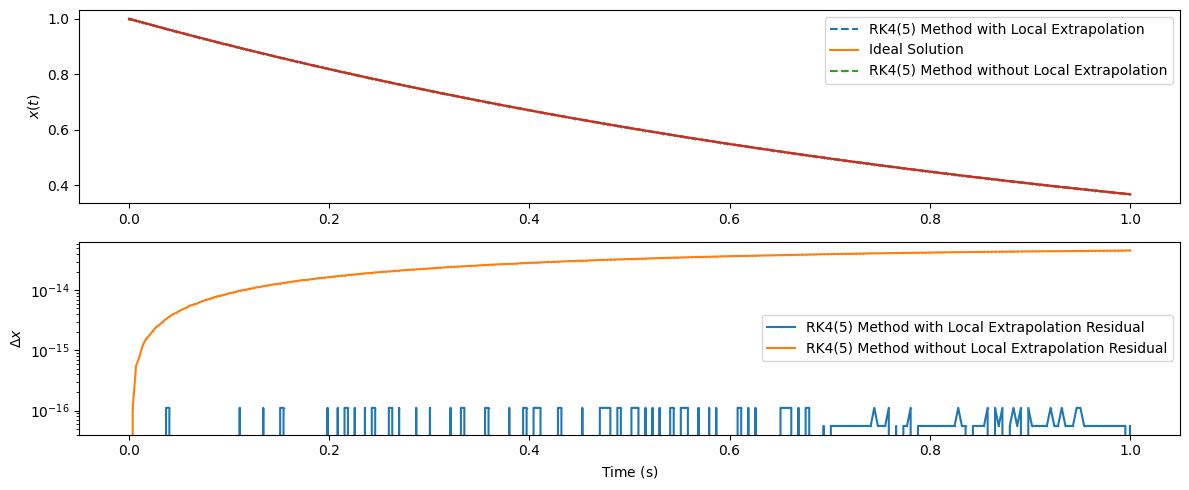

In [12]:
dt = (t1 - t0)/1e6

_, sub_states_upper, state_errors_upper = adaptive_rk45_integrator_with_local_extrapolation.apply(exponential_fn, x0, t0, t1, dt, torch.tensor(5e-16), torch.tensor(5e-16))
_, sub_states_lower, state_errors_lower = adaptive_rk45_integrator_without_local_extrapolation.apply(exponential_fn, x0, t0, t1, dt, torch.tensor(5e-16), torch.tensor(5e-16))

print(f"Error in {adaptive_rk45_integrator_with_local_extrapolation}:    {(sub_states_upper[-1][0] - exponential_fn_solution(x0, t1)).abs().item()}")
print(f"Error in {adaptive_rk45_integrator_without_local_extrapolation}: {(sub_states_lower[-1][0] - exponential_fn_solution(x0, t1)).abs().item()}")

reference_trajectory = [exponential_fn_solution(x0, t) for _,t in sub_states_upper]
fig, axes = neuralode.plot.trajectory.plot_trajectory_with_reference(sub_states_upper, reference_trajectory, method_label="RK4(5) Method with Local Extrapolation")
# axes[1].plot([t.item() for _, t in sub_states_upper], [e.abs().item() for e in state_errors_upper], marker='x', label="Estimated Error")
# axes[1].legend()

reference_trajectory = [exponential_fn_solution(x0, t) for _,t in sub_states_lower]
fig, axes = neuralode.plot.trajectory.plot_trajectory_with_reference(sub_states_lower, reference_trajectory, method_label="RK4(5) Method without Local Extrapolation", axes=axes)
# axes[1].plot([t.item() for _, t in sub_states_lower], [e.abs().item() for e in state_errors_lower], marker='x', label="Estimated Error")
# axes[1].legend()